In [1]:
import xarray as xr
from datetime import datetime
import numpy as np
from datetime import timedelta
from climpy.hazard.condition import MaskArea, ThresholdQuantile, ConnectStructure
from climpy.hazard.criterion import PointHazardCriterion
from climpy.hazard.hazard import PointHazard
from climpy.hazard.event import EventSelector, TimeBetweenEvents

In [2]:
catch_id = 6337060

shp_path = f"/data/compoundx/GRDC_runoff/Xie_bnd/individual_shp/{catch_id}.geojson"
input_dir = '/data/compoundx/causal_flood/grdc/GRDC-Daily.nc'
runoff = xr.open_dataset(input_dir)["runoff_mean"].sel(id = catch_id)
met_path = f"/data/compoundx/causal_flood/basins_gridded/observations_meteorological/{catch_id}/"
tavg_data = xr.open_dataset(met_path + "tavg.nc")["tavg"]

In [3]:
quantile = 0.9
structure = np.array([1,1,1])

flood_criterion = PointHazardCriterion([
    ThresholdQuantile('>', quantile),
    ConnectStructure(structure)
])

In [4]:
flood = PointHazard(flood_criterion)
flood.apply_criterion(runoff)

In [5]:
event_list = flood.all_events()

In [6]:
es = EventSelector(event_list).filter_by_rule( TimeBetweenEvents( '>', timedelta(days=10)))

TypeError: list indices must be integers or slices, not list

In [9]:
ma = MaskArea(shp_path)
masked_tavg = ma(tavg_data)

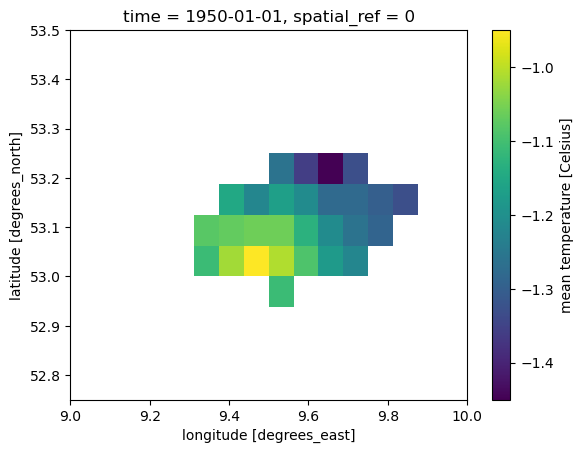

In [10]:
masked_tavg[0,:,:].plot()

<xarray.DataArray 'runoff_mean' (time: 78915)>
[78915 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-01 1806-01-02 ... 2022-01-22
    id       int32 6337060
Attributes:
    units:      m3/s
    long_name:  Mean daily discharge (Q)

In [5]:
quantile = 0.9
structure = np.array([1,1,1])
flood_criterion = PointHazardCriterion([ThresholdPercentile('>', quantile),
                                       ConnectStructure(structure)])

In [6]:
flood = PointHazard(criterion = flood_criterion)
flood.apply_criterion(runoff)

()
<xarray.DataArray 'runoff_mean' (time: 78915)>
[78915 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1806-01-01 1806-01-02 ... 2022-01-22
    id       int32 6337060
Attributes:
    units:      m3/s
    long_name:  Mean daily discharge (Q)


In [12]:
flood.get_event(230)

Areal Hazard Event:
    * Temporal Extent: 2002-08-12 00:00:00 to 2002-08-15 00:00:00

In [20]:
x = ma(mhmOutput)


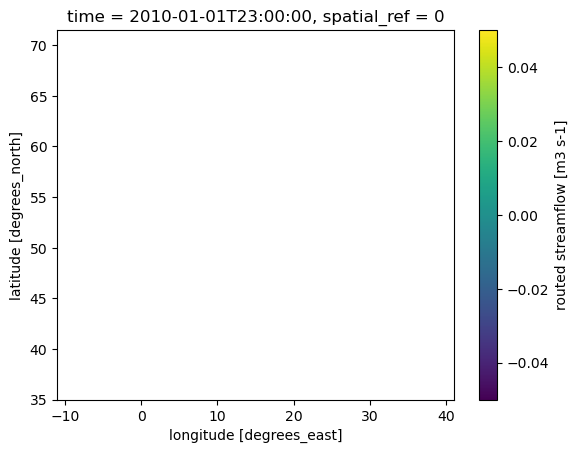

In [21]:
x[0,:,:].plot()

In [14]:
input_dir = '/data/compoundx/E-OBS/dataFor_mhm_EUdrought2022/E-OBS_1920_2022_rawData_0.125/'
mhmOutput = xr.open_dataset(input_dir + 'hydro_mhmOutput/mRM_Fluxes_States.nc')["Qrouted"]
mhmOutput = mhmOutput.sel(time = slice(datetime(2010, 1,1), datetime(2013, 1,1)))

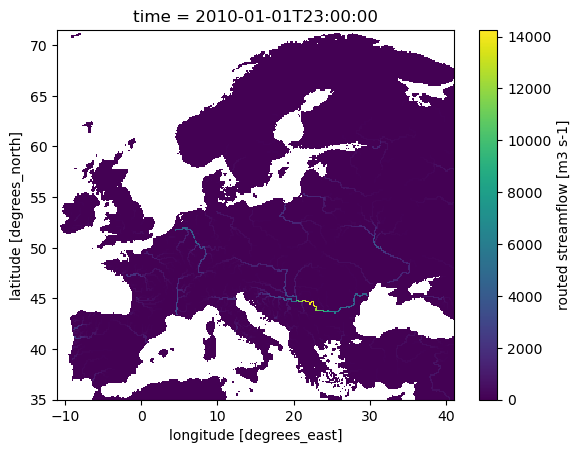

In [15]:
mhmOutput[0, :,:].plot()

In [16]:

ma = MaskArea(shp_file)
x = ma(mhmOutput)
# aa = AverageArea()
# x = aa(x)

AttributeError: 'str' object has no attribute 'geometry'